<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install genice to generate the structure of ice.
! pip install genice2

## benchmark test

In [7]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time



In [8]:
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2        

## Buch's algorithm

2つの隣接する酸素の間に、水素のサイトが二箇所ある。Buchのアルゴリズムは、すべての水素が二箇所のいずれかをランダムに占有した状態を初期配置とする。

初期配置では、水素を過剰にもつ酸素が多数ある。そのような酸素から水素をmigrateして隣りの酸素に渡し、それをランダムに繰り返すことで、すべての酸素に水素が2個ずつになるまで繰り返す。


In [ ]:
def migrate(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    while len(excess) > 0:
        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)

lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(2,))
water      = Molecule("spce")
            
buch = []
for i in (2,4,8,12,16,18,20,22,24):
    raw = GenIce(lattice, rep=[i,i,i]).generate_ice(water, formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep  = 0
    while delta < 2.0:
        # すべての辺をランダムに向けた有向グラフを再生成する。
        dd = nx.DiGraph()
        for a,b in g.edges():
            if random.randint(0,1) == 1:
                dd.add_edge(a,b)
            else:
                dd.add_edge(b,a)

        now = time.time()
        migrate(dd, set([x for x in dd.nodes if len(list(dd.successors(x)))>2]))
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    buch.append([Nnode,delta, Nrep])
    print(Nnode, delta, Nrep, "buch")
    test_icerule(dd, Nnode)

## GenIce algorithm

第一段階の、サイクルによるタイリングを実装。

In [ ]:
from collections import defaultdict

def find_cycle(g, chain):
    head = chain[-1]
    last = -1
    if len(chain) > 1:
        last = chain[-2]
    nexts = [i for i in g[head] if i != last]
    while True:
        last=head
        head = random.choice(nexts)
        if head in chain:
            i = chain.index(head)
            return chain[:i], chain[i:]
        chain.append(head)
        nexts = [i for i in g[head] if i != last]

def remove_cycle(g, cycle):
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        g.remove_edge(a,b)
        if g.degree(a) == 0:
            g.remove_node(a)
        if g.degree(b) == 0:
            g.remove_node(b)


def tileByCycles(g):
    chain = []
    while g.number_of_nodes() > 0:
        if len(chain) == 0:
            head = random.choice(list(g.nodes()))
            chain = [head]
        chain, cycle = find_cycle(g, chain)
        yield cycle
        remove_cycle(g, cycle)


lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(2,))
water      = Molecule("spce")

gen  = []
for i in (2,4,8,12,16,18,20,22,24):
    raw = GenIce(lattice, rep=[i,i,i]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = d.number_of_nodes()

    # 一旦無向グラフになおし、

    delta = 0.0
    Nrep  = 0
    while delta < 5.0:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        for cycle in tileByCycles(g):
            if random.randint(0,1) == 0:
                for i in range(len(cycle)):
                    a,b = cycle[i-1], cycle[i]
                    dd.add_edge(a,b)
            else:
                for i in range(len(cycle)):
                    a,b = cycle[i-1], cycle[i]
                    dd.add_edge(b,a)
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    gen.append([Nnode,delta,Nrep])
    print(Nnode, delta, Nrep, "GenIce")
    test_icerule(dd, Nnode)


## Rahman's algorithm

このアルゴリズムは、あらかじめ脱分極された構造を準備しておき、ランダムに選んだhomodromic cycleを次々に反転することで、水素無秩序構造を生成する。

ここでは、GenIceにより生成した氷Icの構造を出発点とし、すべての辺が少なくとも一度は反転するまで手続きを繰り返す。

In [ ]:
import random

def six(d, Nnode):
    """
    find a cyclic path in the given digraph.
    d: digraph (networkx.DiGraph)
    """
    head = random.randint(0, Nnode-1)
    path = [head]
    while True:
        nexts = list(d.neighbors(head))
        next = random.choice(nexts)
        if next in path:
            i = path.index(next)
            return path[i:]
        path.append(next)
        head = next

def invertCycle(d, cycle, g):
    for i in range(len(cycle)):
        a, b = cycle[i-1], cycle[i]
        d.remove_edge(a,b)
        d.add_edge(a,b)
        # footprint
        if g.has_edge(a,b):
            g.remove_edge(a,b)


lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(3,)) # We need the directed graph of ice!
water      = Molecule("spce")

rahman  = []
for i in range(1,20):
    raw = GenIce(lattice, rep=[i,i,i]).generate_ice(water, formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep  = 0
    while delta < 2.0:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = six(d, d.number_of_nodes())
            invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    rahman.append([Nnode,delta, Nrep])
    print(Nnode, delta, Nrep, "Rahman")
    test_icerule(d, Nnode)
    if delta > 50:
        break


Text(0, 0.5, 'Time / s')

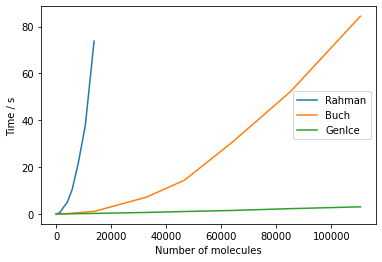

In [ ]:
from matplotlib import pyplot as plt


buch = np.array(buch)
gen  = np.array(gen)
rahman = np.array(rahman)

plt.plot(rahman[:,0], rahman[:,1], label="Rahman")
plt.plot(buch[:,0], buch[:,1], label="Buch")
plt.plot(gen[:,0], gen[:,1], label="GenIce")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")



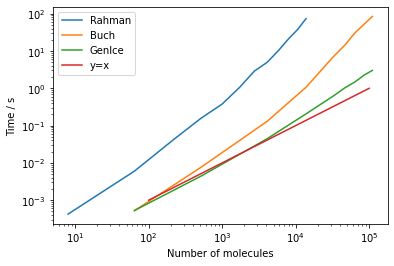

In [ ]:
plt.loglog(rahman[:,0], rahman[:,1], label="Rahman")
plt.loglog(buch[:,0], buch[:,1], label="Buch")
plt.loglog(gen[:,0], gen[:,1], label="GenIce")
plt.loglog(lin, lin*1e-5, label="y=x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")
lin = np.linspace(1e2, 1e5,100)
